In [15]:
import torch
import torch.nn as nn

class DilatedConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(DilatedConvNet, self).__init__()
        layers = []
        for dilation in dilation_rates:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels  # Keep feature size consistent
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class Autoencoder(nn.Module):
    def __init__(self, num_input_channels=1, num_features=4, num_output_channels=3,num_filters=32):
        super(Autoencoder, self).__init__()
        
        # Encoder: DilatedConvNet1 + Projection
        self.encoder = nn.Sequential(
            DilatedConvNet(num_input_channels, num_filters, dilation_rates=[1,2]),
            nn.Conv2d(num_filters, num_features, kernel_size=1)  # Projection to 4 features
        )
        
        # Decoder: Projection + DilatedConvNet2
        self.decoder_1 = nn.Sequential(
             # Expand back to num_filters
            DilatedConvNet(num_features, num_filters,  dilation_rates=[1,2]),  # Reconstruction
            nn.Conv2d(num_filters, num_input_channels,kernel_size=1)
        )

        self.decoder_2 = nn.Sequential(
            # Expand back to num_filters
            DilatedConvNet(num_features, num_filters,  dilation_rates=[1,2]),  # Reconstruction
            nn.Conv2d(num_filters, num_output_channels,kernel_size=1)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder_1(latent)
        predicted = self.decoder_2(latent)
        return reconstructed, predicted

# Example usage
model = Autoencoder(num_input_channels=13, num_features=4, num_filters=16)
input_tensor = torch.randn(1, 13, 128, 64)  # (batch, channels, height, width)
output1, output2 = model(input_tensor)

print("Input Shape:", input_tensor.shape)
print("Output Shape:", output1.shape)  # Should match input shape
print("Output Shape:", output2.shape)  # Should match input shape


Input Shape: torch.Size([1, 13, 128, 64])
Output Shape: torch.Size([1, 13, 128, 64])
Output Shape: torch.Size([1, 3, 128, 64])


In [62]:
import netCDF4 as nc
from global_land_mask import globe
tb_patches=[]
ny=32
import tqdm
import numpy as np
for f in tqdm.tqdm(fs[:]):
    with nc.Dataset(f) as ds:
        tc=ds['S1/Tc'][:]
        lon=ds['S1/Longitude'][:]
        lat=ds['S1/Latitude'][:]
        land_mask=globe.is_land(lat[:,:],lon[:,:])
        land_mask_int=land_mask.astype(np.int8)
        nchunks=tc.shape[0]//128
        for i in range(nchunks):
            chunk=tc[i*128:(i+1)*128,101-ny:101+ny,:]
            land_pixels=land_mask_int[i*128:(i+1)*128,101-ny:101+ny].sum()
            if chunk.data.min()<0:
                continue
            a=np.nonzero(chunk<0)[0]
            if land_pixels/(128*64)<0.05 and len(a)==0:
                tb_patches.append(chunk.copy())
        #break
print(len(tb_patches))

100%|██████████| 70/70 [00:12<00:00,  5.51it/s]

900


In [17]:
#np.savez_compressed('tb_patches.npz',tb_patches=tb_patches)
import glob
import numpy as np
fs=sorted(glob.glob("tb_patches_2020*.npz"))
X=[]
col_wv=[]
col_cloud_liq=[]
near_sfc_rain=[]
for f in fs[:4]:
    d=np.load(f)
    X.extend(d['tb_patches'].astype(np.float32))
    col_wv.extend(d['col_wv_OE'])
    d_temp=d['near_sfc_rain']
    a=np.nonzero(d_temp>-0.01)
    d_temp[a]=np.log10(1+d_temp[a]/0.1)
    near_sfc_rain.extend(d_temp.copy())
    col_cloud_liq.extend(d['col_cloud_liquid'])
X=np.array(X)
X=np.moveaxis(X,3,1)
X=X.astype(np.float32)

In [27]:
col_wv=np.array(col_wv)

np.mean(col_wv[a]),np.std(col_wv[a])
col_cloud_liq=np.array(col_cloud_liq)
a=np.nonzero(col_cloud_liq>=0)
np.mean(col_cloud_liq[a]),np.std(col_cloud_liq[a])
col_cloud_liq_mean=np.mean(col_cloud_liq[a])
col_cloud_liq_std=np.std(col_cloud_liq[a])
near_sfc_rain=np.array(near_sfc_rain)
a=np.nonzero(near_sfc_rain>=0)
np.mean(near_sfc_rain[a]),np.std(near_sfc_rain[a])
near_sfc_rain_mean=np.mean(near_sfc_rain[a])
near_sfc_rain_std=np.std(near_sfc_rain[a])
a=np.nonzero(col_wv>=0)
col_wv_mean=np.mean(col_wv[a])
col_wv_std=np.std(col_wv[a])
y_target=np.concatenate([col_wv[:,np.newaxis,:,:],col_cloud_liq[:,np.newaxis,:,:],near_sfc_rain[:,np.newaxis,:]],axis=1)


In [41]:
mask_y=(y_target>=0).astype(np.float32)
y_target[:,0,:,:]=(y_target[:,0,:,:]-col_wv_mean)/col_wv_std
y_target[:,1,:,:]=(y_target[:,1,:,:]-col_cloud_liq_mean)/col_cloud_liq_std
y_target[:,2,:,:]=(y_target[:,2,:,:]-near_sfc_rain_mean)/near_sfc_rain_std


In [6]:
print(d.keys())
near_sfc_rain=np.array(near_sfc_rain)
col_wv=np.array(col_wv)
col_cloud_liq=np.array(col_cloud_liq)

KeysView(NpzFile 'tb_patches_2020_04.npz' with keys: tb_patches, x_lonL, x_latL, col_wv_OE, near_sfc_rain...)


In [29]:
X_mean=X.mean(axis=0)
X_std=X.std(axis=0)
X_norm=(X-X_mean)/X_std
import pickle
d={'X_mean':X_mean,'X_std':X_std}
pickle.dump(d,open('tb_mean_std.pkl','wb'))

In [144]:
X1D=X_norm[:,:,:,5:-5]
X1D=np.moveaxis(X1D,1,-1)
X1D=X1D.reshape(-1,9)
from sklearn.decomposition import PCA
pca=PCA(n_components=0.975)
pca.fit(X1D)
print(pca.n_components_)
print(pca.explained_variance_ratio_.cumsum())

3
[0.81508625 0.9359002  0.9788293 ]


In [30]:
import torch
X_torch=torch.tensor(X_norm,dtype=torch.float32)
y_torch=torch.tensor(y_target,dtype=torch.float32)
mask_torch=torch.tensor(mask_y,dtype=torch.float32) 
model = Autoencoder(num_input_channels=9, num_features=4, num_output_channels=3, num_filters=8)
dataset = torch.utils.data.TensorDataset(X_torch, y_torch,mask_torch)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()



In [ ]:

n_epochs = 10
for epoch in range(n_epochs):
    avg_loss = 0
    for inputs, target, mask_ in dataloader:
        optimizer.zero_grad()
        outputs, y_ = model(inputs)
        loss1 = criterion(outputs, inputs)
        loss2 = criterion(y_*mask_, target*mask_)
        loss=loss1+loss2
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss/len(dataloader)}")

Epoch 1/10, Loss: 0.18038182249709742


In [37]:
scripted_model = torch.jit.script(model)
scripted_model.save("model_2outputs.pt")
#model=torch.jit.script(model)
x_rec, y_pred=model(X_torch)

In [40]:
print(z.shape)
print(near_sfc_rain.shape)
y_pred_numpy=y_pred.detach().numpy()
a=np.nonzero(col_wv>0)

print(np.corrcoef(y_pred_numpy[:,0,:,:][a].flatten(),col_wv[a].flatten()))
b=np.nonzero(col_cloud_liq>=0)
print(np.corrcoef(y_pred_numpy[:,1,:,:][b].flatten(),col_cloud_liq[b].flatten()))
c=np.nonzero(near_sfc_rain>=0)
print(np.corrcoef(y_pred_numpy[:,2,:,:][c].flatten(),near_sfc_rain[c].flatten()))



torch.Size([4281, 4, 128, 64])
(4281, 128, 64)
[[1.         0.98850881]
 [0.98850881 1.        ]]
[[1.        0.8620601]
 [0.8620601 1.       ]]
[[1.         0.81561243]
 [0.81561243 1.        ]]


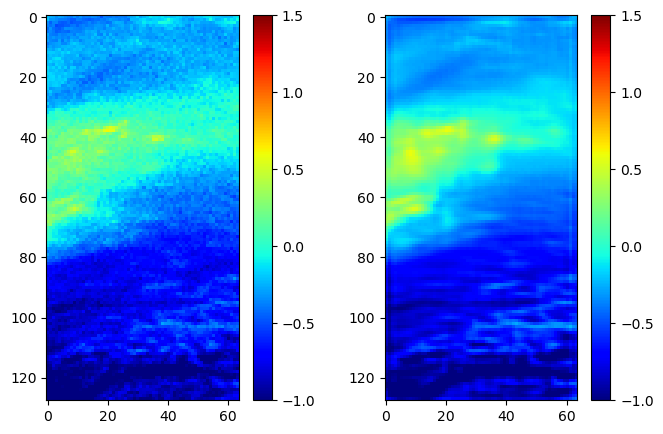

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.subplot(121)
plt.imshow(inputs.detach().numpy()[0,2,:,:],cmap='jet',vmin=-1,vmax=1.5)
plt.colorbar()
plt.subplot(122)    
plt.imshow(outputs.detach().numpy()[0,2,:,:],cmap='jet',vmin=-1,vmax=1.5)
plt.colorbar()


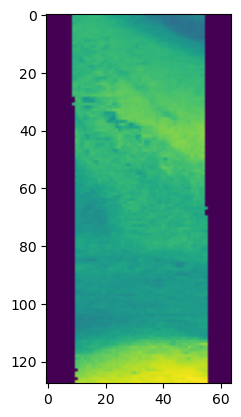

In [74]:
tb_patches=d['tb_patches']
col_wv_OE=d['col_wv_OE']
import matplotlib.pyplot as plt
plt.imshow(tb_patches[0,:,:,1])
plt.imshow(col_wv_OE[0,:,:],vmin=0)

In [69]:
import re

input_string = '1C.GPM.GMI.XCAL2016-C.20210115-S062943-E080216.039103.V07A.HDF5'

year = re.findall(r'\d{4}', input_string)[0]
month = re.findall(r'\d{2}', input_string)[0]
day = re.findall(r'\d{2}', input_string)[1]
orbit = re.findall(r'\d{5,6}', input_string)[0]

print(year)  # 2021
print(month)  # 01
print(day)    # 15
print(orbit)  # 039103

s = '1C.GPM.GMI.XCAL2016-C.20210115-S062943-E080216.039103.V07A.HDF5'

parts = s.split('-')
date_part = parts[1]
orbit_part = parts[-1]

year = int(date_part[2:6])
month = int(date_part[6:8])
day = int(date_part[8:10])

orbit = orbit_part.split('.')[1]

print(f"Year: {year}")
print(f"Month: {month}")
print(f"Day: {day}")
print(f"Orbit: {orbit}")


2016
20
16
202101
Year: 2021
Month: 1
Day: 15
Orbit: 039103


78.88


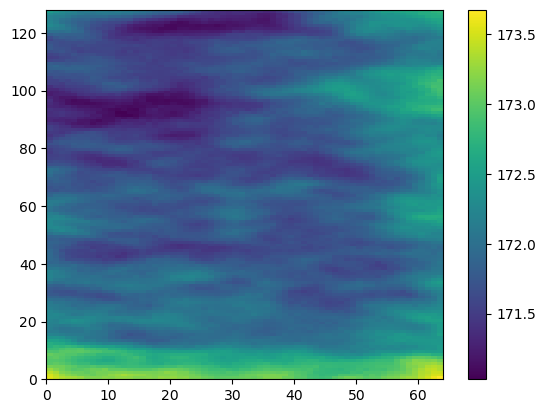

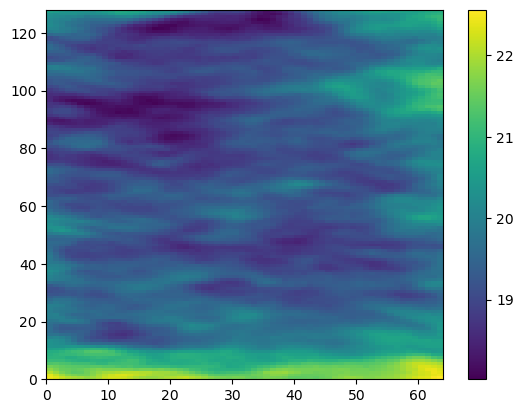

In [64]:
tb_mean=np.array(tb_patches).mean(axis=0)
tb_std=np.array(tb_patches).std(axis=0)
plt.pcolormesh(tb_mean[:,:,0])
plt.colorbar()
tb_patches=np.array(tb_patches)
print(tb_patches.min())
plt.figure()
plt.pcolormesh(tb_std[:,:,0])
plt.colorbar()

In [ ]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
ax=plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lon[1650:3000],lat[1650:3000],land_mask[1650:3000],transform=ccrs.PlateCarree())
ax.coastlines()
land_mask_int=land_mask.astype(dtype='uint8')
print(tc.shape)
ny=32
tc[:,101-ny:101+ny,:].shape


    #break

IndentationError: unexpected indent (1122326166.py, line 13)

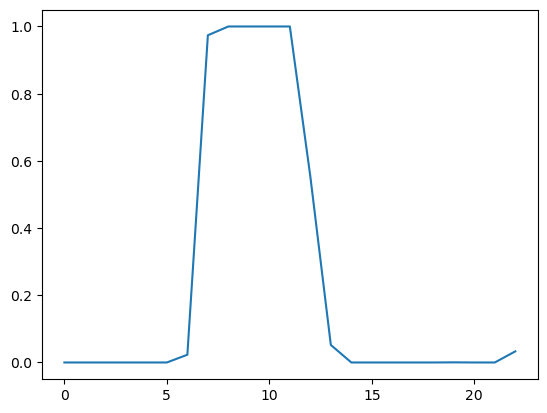

In [35]:
import numpy as np
plt.plot(np.array(land_pixels_list)/(128*64))

In [12]:
lon.min(),lon.max(),lat.min(),lat.max()

(-179.99873, 179.99911, -69.4083, 69.41952)